# Mandelbrot Fractals with `Gopjrt`

This Go notebook compares drawing mandelbrot fractals generated using pure Go, and using XLA and 2080Ti Nvidia GPU.

Short recap of [Mandelbrot Set](https://en.wikipedia.org/wiki/Mandelbrot_set):
* The generated image is defined over a plane of complex values ($x$ represents the real value, $y$ represents the imaginary value.
* The value at each pixel is the number of iterations ($n$) of the function $z(n+1)=z(n)^2+c$ diverge, where $c$ is the complex number `complex(x,y)`, and we assume that "diverge" is when $|z(n)| > 2$.
* We map the log of the number of iterations to diverge to a corresponding color -- we take the log to decrease the contrast.


## Normal Go Version

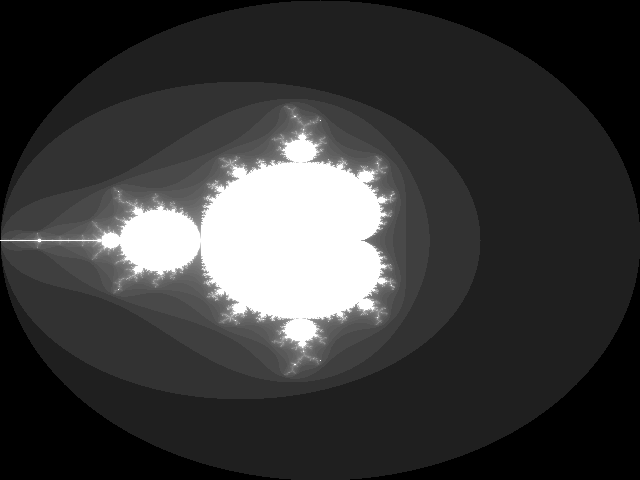

In [33]:

import (
    "github.com/janpfeifer/must"
    "github.com/janpfeifer/gonb/gonbui"
    "github.com/chewxy/math32"
)

func c64Abs(c complex64) float32 {
    return math32.Hypot(real(c), imag(c))
}

func mandelbrot(cx, cy float32, maxIterations int) int {
    c := complex(cx, cy)
    z := complex(float32(0), float32(0))
    for n := 0; n < maxIterations; n++ {
        z = z*z + c
        if c64Abs(z) > 2 {
            return n
        }
    }
    return maxIterations
}

func mandelbrotGo(width, height, maxIterations int, xmin, ymin, xmax, ymax float32) *image.RGBA {
    img := image.NewRGBA(image.Rect(0, 0, width, height))
    logMaxIterations := math32.Log(float32(maxIterations+1))
    for y := 0; y < height; y++ {
        cy := ymin + (ymax-ymin)*float32(y)/float32(height)
        for x := 0; x < width; x++ {
            cx := xmin + (xmax-xmin)*float32(x)/float32(width)
            iter := mandelbrot(cx, cy, maxIterations)

            // Map iteration count to color
            colorVal := uint8(255 * math32.Log(float32(iter+1)) / logMaxIterations)
            img.Set(x, y, color.RGBA{colorVal, colorVal, colorVal, 255})
        }
    }
    return img
}

%%
must.M(gonbui.DisplayImage(
mandelbrotGo(640, 480, 256, -2, -2, 2, 2)))


## Gopjrt version

Same computation as above, but done in a vectorial fashion.

First we use the `gopjrt` package from the local disk: only needed if the `gopjrt` is cloned locally.

In [15]:
!*rm -f go.work && go work init && go work use . ${HOME}/Projects/gopjrt
%goworkfix
%env LD_LIBRARY_PATH=/usr/local/lib

	- Replace rule for module "github.com/gomlx/gopjrt" to local directory "/home/janpf/Projects/gopjrt" already exists.
Set: LD_LIBRARY_PATH="/usr/local/lib"


We create a container for the PJRT plugin and compiled code. The image size, number of iterations are fixed. But then we can execute it really fast for different areas (xmin, ymin, xmax and ymax).

Compiling XLA program:
Generating image:


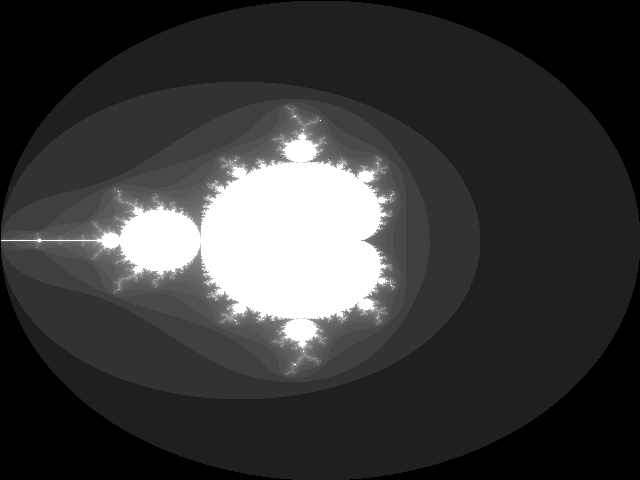

In [57]:
import (
    "flag"
    "github.com/gomlx/gopjrt/dtypes"
    "github.com/gomlx/gopjrt/pjrt"
    xla "github.com/gomlx/gopjrt/xlabuilder"
)

var flagPluginName = flag.String("plugin", "cuda", "PRJT plugin name or full path")

type MandelbrotGenerator struct {
    plugin *pjrt.Plugin
    client *pjrt.Client
    width, height, maxIterations int
    exec *pjrt.LoadedExecutable
}

func NewMandelbrotGenerator(width, height, maxIterations int) *MandelbrotGenerator {
    pjrt.SuppressAbseilLoggingHack()
    m := &MandelbrotGenerator{
     	plugin: must.M1(pjrt.GetPlugin(*flagPluginName)),
        width: width,
        height: height,
        maxIterations: maxIterations,
    }
    m.client = must.M1(m.plugin.NewClient(nil))
    m.Build()
    return m
}

func (m *MandelbrotGenerator) Build() {
    builder := xla.New("mandelbrot")
    dtype := dtypes.F32
    scalarShape := xla.MakeShape(dtype)
    imageShape := xla.MakeShape(dtype, m.height, m.width)
    minX := must.M1(xla.Parameter(builder, "minX", 0, scalarShape))
    minY := must.M1(xla.Parameter(builder, "minY", 1, scalarShape))
    maxX := must.M1(xla.Parameter(builder, "maxX", 2, scalarShape))
    maxY := must.M1(xla.Parameter(builder, "maxY", 3, scalarShape))
    _, _ = minY, maxY

    cx := must.M1(xla.Iota(builder, imageShape, 1))
    normalizeX := must.M1(xla.Div(
        must.M1(xla.Sub(maxX, minX)),
        must.M1(xla.Constant(builder, xla.NewScalarLiteral(float32(m.width))))))
    cx = must.M1(xla.Mul(cx, normalizeX))
    cx = must.M1(xla.Add(cx, minX))

    cy := must.M1(xla.Iota(builder, imageShape, 0))
    normalizeY := must.M1(xla.Div(
        must.M1(xla.Sub(maxY, minY)),
        must.M1(xla.Constant(builder, xla.NewScalarLiteral(float32(m.height))))))
    cy = must.M1(xla.Mul(cy, normalizeY))
    cy = must.M1(xla.Add(cy, minY))

    c := must.M1(xla.Complex(cx, cy))
    z := must.M1(xla.Mul(c, must.M1(xla.ScalarZero(builder, dtypes.C64))))

    zero := must.M1(xla.ScalarZero(builder, dtype))
    zeroC64 := must.M1(xla.ScalarZero(builder, dtypes.C64))
    one := must.M1(xla.ScalarOne(builder, dtype))
    currentIter := zero
    maxIter := must.M1(xla.Constant(builder, xla.NewScalarLiteral(float32(m.maxIterations))))
    
    result := must.M1(xla.Broadcast(maxIter, imageShape.Dimensions...))
    divergeLimit := must.M1(xla.Constant(builder, xla.NewScalarLiteral(float32(2))))

    for _ = range m.maxIterations {
        z = must.M1(xla.Mul(z, z))
        z = must.M1(xla.Add(z, c))

        diverged := must.M1(xla.GreaterOrEqual(must.M1(xla.Abs(z)), divergeLimit))
        resultUpdate := must.M1(xla.Min(result, currentIter))
        result = must.M1(xla.Where(diverged, resultUpdate,result))
        z = must.M1(xla.Where(diverged, zeroC64, z))

        currentIter = must.M1(xla.Add(currentIter, one))
    }
    comp := must.M1(builder.Build(result))
    m.exec = must.M1(m.client.Compile().WithComputation(comp).Done())
}

func (m *MandelbrotGenerator) Exec(minX, minY, maxX, maxY float32) *image.RGBA {
    inputs := make([]*pjrt.Buffer, 4)
    for ii, value := range []float32{minX, minY, maxX, maxY} {
        inputs[ii] = must.M1(pjrt.ScalarToBuffer(m.client, value))
    }
    outputBuffer := must.M1(m.exec.Execute(inputs...).Done())[0]
    flat, _ := must.M2(pjrt.BufferToArray[float32](outputBuffer))
    img := image.NewRGBA(image.Rect(0, 0, m.width, m.height))
    pos := 0
    logMaxIterations := math32.Log(float32(m.maxIterations+1))
    for y := 0; y < m.height; y++ {
        for x := 0; x < m.width; x++ {
            // Map iteration count to color
            colorVal := uint8(255 * math32.Log(flat[pos]+1) / logMaxIterations)
            pos++
            img.Set(x, y, color.RGBA{colorVal, colorVal, colorVal, 255})
        }
    }
    return img
}

%%
fmt.Println("Compiling XLA program:")
m := NewMandelbrotGenerator(640, 480, 256)
fmt.Println("Generating image:")
must.M(gonbui.DisplayImage(
    m.Exec(-2, -2, 2, 2)))


## Benchmark on large resolution image

We use a reference image of 10000x10000 pixels, with 256 iterations.
    
| **Configuration** | **Go CPU** | **PJRT CPU** | **PJRT GPU** |
|:---:|:---:|:---:|:---:|
| Intel i9-12900K+Nvidia2080Ti GPU | 17.1s | 4.7s | 2.4s |


In [56]:
%test -test.bench=. -test.run=Benchmark --plugin=cuda

const (
    benchmarkWidth = 10000
    benchmarkHeight = 10000
    benchmarkIterations = 256
)

func BenchmarkMandelbrotGo(b *testing.B) {
    _ = mandelbrotGo(benchmarkWidth, benchmarkHeight, benchmarkIterations, -2, -2, 2, 2)
}

func BenchmarkMandelbrotPJRT(b *testing.B) {
    var m *MandelbrotGenerator
    b.Run("compile", func (b *testing.B) {
        for i := 0; i < b.N; i++ {
            m = NewMandelbrotGenerator(benchmarkWidth, benchmarkHeight, benchmarkIterations)
        }
    })
    b.Run("exec", func (b *testing.B) {
        for i := 0; i < b.N; i++ {
            _ = m.Exec(-2, -2, 2, 2)     
        }
    })
}

goos: linux
goarch: amd64
pkg: gonb_a55647d4
cpu: 12th Gen Intel(R) Core(TM) i9-12900K
BenchmarkMandelbrotGo-24      	       1	17064961939 ns/op
BenchmarkMandelbrotPJRT/compile-24         	       1	3813693347 ns/op
BenchmarkMandelbrotPJRT/exec-24            	       1	2436059611 ns/op
PASS
